In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import imageio
from math import pi, sin, cos
from scipy.optimize import NonlinearConstraint, minimize

# Mass and stiffness parameters
m = 15.0        # kg
k = 900.0      # N/m
b = 50.0        # Damping in vertical direction
I = m*(0.75**2) # Moment of inertia about COM
b_v = 0.1       # Damping in x-direction for the virtual model
k_v = 1.2       # gain
h = .8          # height in meters
leg_d = 0.4    # length of leg segments

# Desired velocity for virtual model
x_dotdes = 1.0  # m/s

# Initial state: [x, x_dot, y, y_dot, theta, theta_dot, front_leg_x, back_leg_x]
# 8 states
fg = -9.81*m
x_start = 0.1
y_start = fg/k + h

q_init = np.array([
    x_start, 
    0.0, 
    y_start, 
    -0.1, 
    0.0, 
    -0.1, 
    x_start*2,  # front_leg_x
    0.0,     # back_leg_x   
])  

q_print = [q_init.copy()]
front_legF = []
back_legF  = []
front_leg_th = []
back_leg_th = []
front_leg_tau = []
back_leg_tau = []

def doubleStance(t, q):
    # Access global-like parameters
    # Compute desired forces
    fy_des   = -k*(q[2] - h) - b*q[3]
    tau_des  = -(k/25.0)*q[4] - b*q[5]
    
    # Distance from COM to leg contacts
    l1 = q[6] - q[0]           # front leg
    l2 = abs(q[7] - q[0])      # back leg

    # Solve for front and back vertical forces so that total torque is tau_des
    #    tau_des = front_leg_y * l1 + (-back_leg_y) * l2  (with sign adjustments)
    #    plus we want sum(front_leg_y + back_leg_y) = fy_des
    # The code does a quick distribution:
    f_fronty = (tau_des + fy_des*l2) / (l1 + l2)
    if f_fronty < 0.0:
        f_fronty = 0.0
    f_backy = fy_des - f_fronty
    if f_backy < 0.0:
        f_backy = 0.0


    f_frontx = (k_v*(x_dotdes - q[1]))**1/2.0
    f_backx  = f_frontx

    # Log forces at this instant
    front_legF.append([t, f_frontx, f_fronty])
    back_legF.append([t,  f_backx,  f_backy])

    # Build dqdt
    dqdt = np.zeros_like(q)
    dqdt[0] = q[1]
    dqdt[1] = (f_frontx + f_backx - b_v*q[1]) / m
    dqdt[2] = q[3]
    dqdt[3] = (f_fronty + f_backy - m*9.81) / m
    dqdt[4] = q[5]
    dqdt[5] = (f_fronty*l1 - f_backy*l2 + f_frontx*0.4 + f_backx*0.4) / I
    dqdt[6] = 0.0
    dqdt[7] = 0.0

    return dqdt

def singleStance(t, q):
    # Vertical force
    fy_des   = -k*(q[2] - h) - b*q[3]
    f_fronty = fy_des
    if f_fronty < 0.0:
        f_fronty = 0.0

    # X-force
    # MATLAB used 5*(k_v*(x_dotdes - q[1]))
    f_frontx = 5.0*(k_v*(x_dotdes - q[1]))
    # if f_frontx < 0, we might force it to 0, but your MATLAB code commented that out

    # Log front leg forces
    front_legF.append([t, f_frontx, f_fronty])

    # Distance from COM to front leg (back_leg_x is zero in single stance)
    l2 = abs(q[6] - q[0])

    dqdt = np.zeros_like(q)
    dqdt[0] = q[1]
    dqdt[1] = (f_frontx - b_v*q[1]) / m
    dqdt[2] = q[3]
    dqdt[3] = (f_fronty - m*9.81) / m
    dqdt[4] = q[5]
    dqdt[5] = (-f_fronty*l2 + f_frontx*0.4) / I

    # front_leg_x and back_leg_x not changing in single stance
    dqdt[6] = 0.0
    dqdt[7] = 0.0

    return dqdt

def jointOptimization(fx, fy, legx, comx, comy):

    def objective(thetas):
            theta1, theta2 = thetas
            return theta1**2
        
        # Define the constraint function which enforces end-effector at (legx, 0)
        # We'll return a vector of two equations that should each be zero.
    def constraints_func(thetas):
        theta1, theta2 = thetas
        x_ee = comx - leg_d * np.cos(theta1) - leg_d * np.cos(theta1 + theta2)
        y_ee = comy - leg_d * np.sin(theta1) - leg_d * np.sin(theta1 + theta2)
        return np.array([x_ee - legx, 
                        y_ee - 0.0, theta1 - 0.0])  # end-effector's y must be 0
    
    # Create a NonlinearConstraint that equals zero for both x_ee and y_ee
    # (residual array [0, 0])
    eq_constraint = NonlinearConstraint(constraints_func, 
                                        lb=[0.0, 0.0, 0.0], 
                                        ub=[0.0, 0.0, pi/2.0])
    
    # Perform optimization
    res = minimize(
        objective, 
        x0=[0,0],          # Initial guess for [theta1, theta2]
        constraints=[eq_constraint],
        method='trust-constr',     # Could also try 'SLSQP' or others
        options={'xtol': 1e-10, 'verbose': 0}
    )
    
    if res.success:
        print("Optimization succeeded:")
    else:
        print("Optimization failed:", res.message)

    theta1, theta2 = res.x

    dx_dtheta1 = leg_d * np.sin(theta1) + leg_d * np.sin(theta1 + theta2)
    dx_dtheta2 = leg_d * np.sin(theta1 + theta2)
    dy_dtheta1 = - leg_d * np.cos(theta1) - leg_d * np.cos(theta1 + theta2)
    dy_dtheta2 = - leg_d * np.cos(theta1 + theta2)

    tau1 = dx_dtheta1 * fx + dy_dtheta1 * fy
    tau2 = dx_dtheta2 * fx + dy_dtheta2 * fy 
    
    return theta1, theta2, tau1, tau2
 

In [38]:
# Simulation parameters
tspan = (0.0, 10.0)
dt = 0.01
current_time = 0.0

#
# -------------------- Time-stepping Loop --------------------
#
times = [current_time]

# We keep integrating until current_time >= tspan[1]
while current_time < tspan[1]:
    q_cur = q_print[-1]
    d_dynamic = q_cur[1]/x_dotdes*0.15 + .05
    # leg switching logic
    if q_cur[6] <= (q_cur[0] - d_dynamic): #Attempting to remove dynamics leg positions q_cur[0] - d_dynamic
        q_cur[7] = q_cur[6]
        q_cur[6] = q_cur[0] + 1.2*d_dynamic

    if q_cur[0] <= q_cur[6]:
        # Double Stance
        sol = solve_ivp(doubleStance, [current_time, current_time+dt], q_cur, 
                        t_eval=[current_time+dt])
        next_state = sol.y[:, -1]
    else:
        q_cur[7] = 0.0
        sol = solve_ivp(singleStance, [current_time, current_time+dt], q_cur,
                        t_eval=[current_time+dt])
        next_state = sol.y[:, -1]
        
    q_print.append(next_state)
    current_time += dt
    times.append(current_time)

# Convert list -> NumPy array for easy slicing
q_print = np.array(q_print)
times = np.array(times)

j = 0
for i in times:
    # Compute thetas and torques
    q = q_print[j]
    for k in front_legF:
        if k[0] == i:
            fx = k[1]
            fy = k[2]
    front_legx = q[6]
    comx = q[0]
    comy = q[2]
    theta1, theta2, tau1, tau2 = jointOptimization(fx, fy, front_legx, comx, comy)
    front_leg_th.append([i, theta1, theta2])
    front_leg_tau.append([i, tau1, tau2])

    for k in back_legF:
        if k[0] == i:
            fx = k[1]
            fy = k[2]
    back_legx = q[7]
    if back_legx == 0:
        back_leg_th.append([i, 0, 0])
        back_leg_tau.append([i, 0, 0])
    else:
        comx = q[0]
        comy = q[2]
        theta1, theta2, tau1, tau2 = jointOptimization(fx, fy, back_legx, comx, comy)
        back_leg_th.append([i, theta1, theta2])
        back_leg_tau.append([i, tau1, tau2])
    j += 1

Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:


/Users/sajivshah/anaconda3/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:81: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization succeeded:
Optimization suc

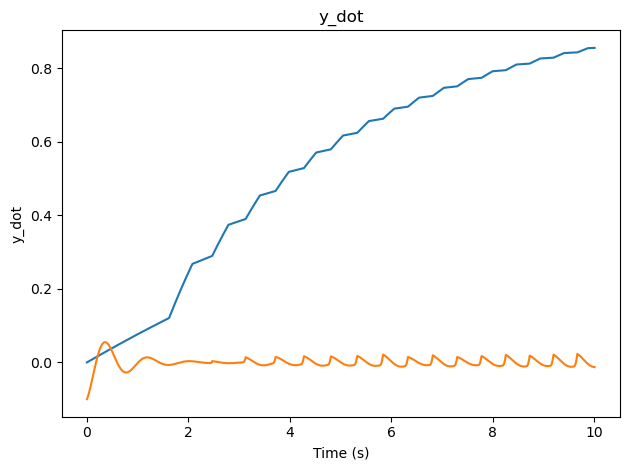

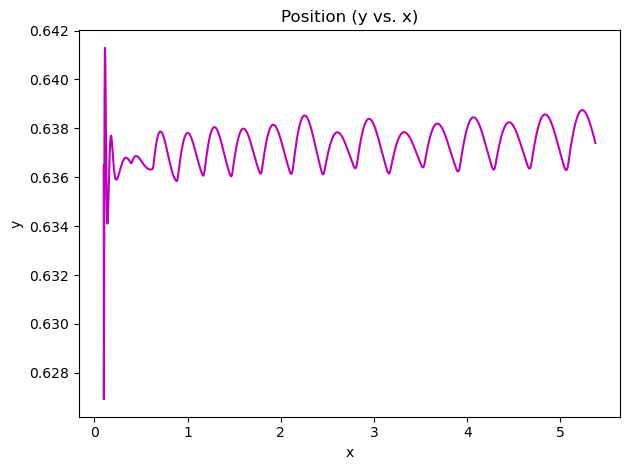

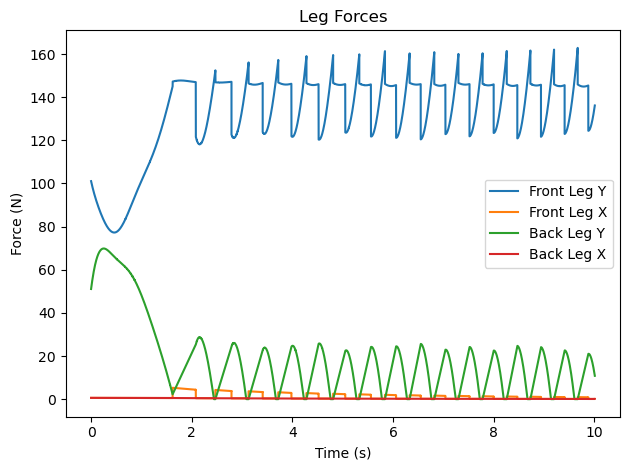

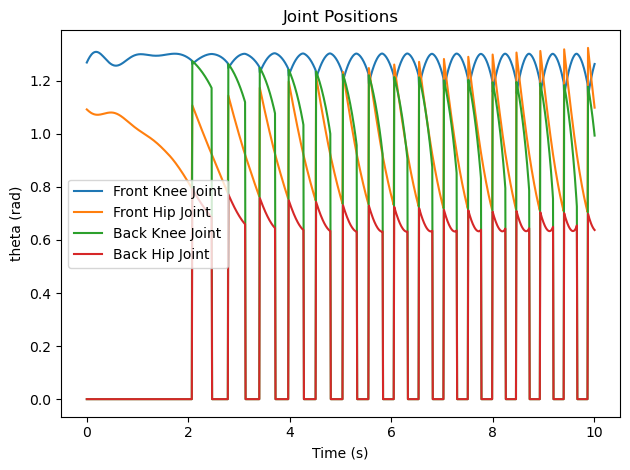

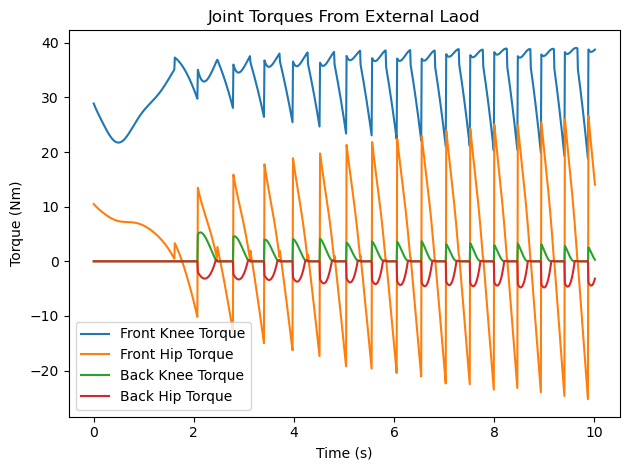

Animation saved as: granny_animation_legs.gif
Done!


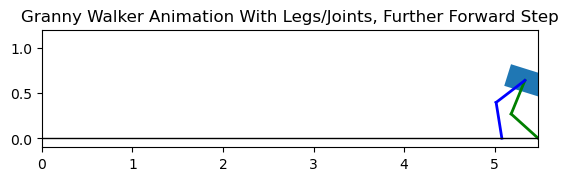

In [39]:
# -------------------- Plotting Each State --------------------
#
state_labels = ["x", "x_dot", "y", "y_dot", "theta", "theta_dot", 
                "front_leg_x", "back_leg_x"]

plt.figure()
for i in range(2):
    plt.plot(times, q_print[:, 2*i+1], '-')
plt.title(state_labels[2*i+1])
plt.xlabel("Time (s)")
plt.ylabel(state_labels[2*i+1])
plt.tight_layout()
plt.show()

# Plot y vs x
plt.figure()
plt.plot(q_print[:, 0], q_print[:, 2], '-m')
plt.title("Position (y vs. x)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

#
# -------------------- Plotting Leg Forces --------------------
#
# Convert front_legF and back_legF to arrays
front_legF = np.array(front_legF)  # shape: (N, 3) => [time, Fx, Fy]
back_legF  = np.array(back_legF)   # shape: (M, 3)

if len(front_legF) > 0:
    plt.figure()
    plt.plot(front_legF[:,0], front_legF[:,2], '-', label="Front Leg Y")
    plt.plot(front_legF[:,0], front_legF[:,1], '-', label = "Front Leg X")
    plt.plot(back_legF[:,0], back_legF[:,2], '-', label="Back Leg Y")
    plt.plot(back_legF[:,0], back_legF[:,1], '-', label = "Back Leg X")
    plt.title("Leg Forces")
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.legend()
    plt.tight_layout()
    plt.show()

front_leg_th = np.array(front_leg_th)
back_leg_th  = np.array(back_leg_th)
front_leg_tau = np.array(front_leg_tau)
back_leg_tau  = np.array(back_leg_tau)

if len(front_leg_th) > 0:
    plt.figure()
    plt.plot(front_leg_th[:,0], front_leg_th[:,2], '-', label="Front Knee Joint")
    plt.plot(front_leg_th[:,0], front_leg_th[:,1], '-', label = "Front Hip Joint")
    plt.plot(back_leg_th[:,0], back_leg_th[:,2], '-', label="Back Knee Joint")
    plt.plot(back_leg_th[:,0], back_leg_th[:,1], '-', label = "Back Hip Joint")
    plt.title("Joint Positions")
    plt.xlabel("Time (s)")
    plt.ylabel("theta (rad)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if len(front_leg_tau) > 0:
    plt.figure()
    plt.plot(front_leg_tau[:,0], front_leg_tau[:,2], '-', label="Front Knee Torque")
    plt.plot(front_leg_tau[:,0], front_leg_tau[:,1], '-', label = "Front Hip Torque")
    plt.plot(back_leg_tau[:,0], back_leg_tau[:,2], '-', label="Back Knee Torque")
    plt.plot(back_leg_tau[:,0], back_leg_tau[:,1], '-', label = "Back Hip Torque")
    plt.title("Joint Torques From External Laod")
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (Nm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------- Animation: Granny Walker --------------------
#
# We animate the box (body) + legs in 2D as a GIF.
filename = "granny_animation_legs.gif"
frames = []
frame_delay = 0.1 # matches your MATLAB frame_delay

# Basic figure settings
fig, ax = plt.subplots()
ax.set_aspect("equal", "box")
ax.set_xlim([0, max(q_print[:,0]) + 0.1])
ax.set_ylim([-0.1, 1.2])
plt.title("Granny Walker Animation With Legs/Joints, Further Forward Step")

# We'll draw a rectangle “box” at each frame, plus two lines for the legs.
# The corners of the rectangle, in local coords:
width  = 0.4
height = 0.25
half_w = 0.5 * width
half_h = 0.5 * height

# We'll store the artists that we update every frame
body_box  = plt.Polygon([[0,0],[0,0],[0,0],[0,0]], closed=True)
leg_line1, = ax.plot([], [], 'g-', lw=2)  # front leg
leg_line2, = ax.plot([], [], 'g-', lw=2)  # front leg
leg_line3, = ax.plot([], [], 'b-', lw=2)  # back leg
leg_line4, = ax.plot([], [], 'b-', lw=2)  # back leg
ground_line, = ax.plot([0, max(q_print[:,0]) + 0.1],[0,0],'k-',lw=1)

ax.add_patch(body_box)

# Animation loop (taking every Nth point for speed)
step = 6
for i in range(0, len(q_print), step):
    x     = q_print[i, 0]
    y     = q_print[i, 2]
    theta = q_print[i, 4]
    fl_t1 = front_leg_th[i][1]
    fl_t2 = front_leg_th[i][2]
    bl_t1 = back_leg_th[i][1]
    bl_t2 = back_leg_th[i][2]

    # Rotation matrix
    R = np.array([[ cos(theta), -sin(theta)],
                  [ sin(theta),  cos(theta)]])

    # corners of the rectangle in local coords
    corners_local = np.array([
        [-half_w, -half_h],
        [ half_w, -half_h],
        [ half_w,  half_h],
        [-half_w,  half_h]
    ])
    # rotate + translate
    corners_global = (R @ corners_local.T).T
    corners_global[:,0] += x
    corners_global[:,1] += (y)  # body offset above the ground

    body_box.set_xy(corners_global)

    # front leg
    if fl_t1 != 0:
        leg_line1.set_xdata([x, x - leg_d*np.cos(fl_t1)])
        leg_line1.set_ydata([y, y - leg_d*np.sin(fl_t1)])
        leg_line2.set_xdata([x - leg_d*np.cos(fl_t1), x - leg_d*np.cos(fl_t1) - leg_d*np.cos(fl_t1 + fl_t2)])
        leg_line2.set_ydata([y - leg_d*np.sin(fl_t1), y - leg_d*np.sin(fl_t1) - leg_d*np.sin(fl_t1 + fl_t2)])
    else:
        # if for some reason fl_x <= 0, we can just keep it “folded”
        leg_line1.set_xdata([x, x])
        leg_line1.set_ydata([y, y])
        leg_line2.set_xdata([x, x])
        leg_line2.set_ydata([y, y])

    # back leg
    if bl_t1 != 0:
        leg_line3.set_xdata([x, x - leg_d*np.cos(bl_t1)])
        leg_line3.set_ydata([y, y - leg_d*np.sin(bl_t1)])
        leg_line4.set_xdata([x - leg_d*np.cos(bl_t1), x - leg_d*np.cos(bl_t1) - leg_d*np.cos(bl_t1 + bl_t2)])
        leg_line4.set_ydata([y - leg_d*np.sin(bl_t1), y - leg_d*np.sin(bl_t1) - leg_d*np.sin(bl_t1 + bl_t2)])
    else:
        leg_line3.set_xdata([x, x])
        leg_line3.set_ydata([y, y])
        leg_line4.set_xdata([x, x])
        leg_line4.set_ydata([y, y])

    # Grab this frame from the figure
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame.copy())

# Save as animated GIF via imageio
with imageio.get_writer(filename, mode='I', duration=frame_delay) as writer:
    for f in frames:
        writer.append_data(f)

print("Animation saved as:", filename)
print("Done!")